# Dynamic gestures recognition


In [3]:
import os
import cv2
import sklearn
import numpy as np

## Load static gestures dataset

In [2]:
import os 
import numpy as np

labels_dict = {"hands_down": 0,
               "stop": 1,
               "hands_up": 2,
               "hands_up_small": 3,
               "hands_down_small": 4,
               "hads_down_up": 5,
               "hands_to_sides": 6}

data_list = []
labels_list = []

normalized_data_dir = "database/static_gestures_with_pose_rescaling"

for folder in os.listdir(normalized_data_dir):
    print(folder)
    src_path = os.path.join(normalized_data_dir, folder)
    for data_file_name in os.listdir(src_path):
        full_data_file_path = os.path.join(src_path, data_file_name)
        features = np.load(full_data_file_path)
        
        if not any(np.isnan(features)):
            data_list.append(features)
            labels_list.append(labels_dict[folder])

print("Loaded")

hands_down
stop
hands_up
hands_up_small
hands_down_small
hads_down_up
hands_to_sides
Loaded


## Split static gestures dataset

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_list, labels_list, stratify=labels_list,
                                                    test_size=0.3, random_state=42)

In [4]:
# from keras.layers import *
# from keras.models import Sequential

# model5 = Sequential()
# model5.add(Dense(28, activation="relu", input_shape=(28,)))

# model5.add(Dense(56, activation="relu"))
# model5.add(Dense(28, activation="relu"))


# model5.add(Dense(7, activation="softmax"))
# model5.compile(optimizer="rmsprop",
#               loss="sparse_categorical_crossentropy",
#               metrics=["acc"])


# train_hist5 = model5.fit(np.array(X_train), np.array(y_train),
#                        epochs=33, batch_size=10,
#                        validation_data=(np.array(X_test), np.array(y_test)), 
#                        verbose=False)
# static_model = model5

from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics


results_dict = {}

# for Cc in range(1, 100):
svm_clf = Pipeline([("scaler", StandardScaler()),
                    ("linear_svc", LinearSVC(C=13, loss="hinge"))])
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
acc = metrics.accuracy_score(y_test, y_pred)
#     results_dict[Cc] = acc

/home/user/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [11]:
acc

0.9523809523809523

In [5]:
static_model = svm_clf

## Load dynamic gestures data

In [6]:
dynamic_gestures_labesl_dict = {0: "stop",
                                1: "come_on",
                                2: "go_away",
                                3: "look_at_me",
                                4: "other"}

gestures_to_num_dict = dict(zip(dynamic_gestures_labesl_dict.values(), dynamic_gestures_labesl_dict.keys()))

full_data = []
full_labels = []

for gesture in gestures_to_num_dict:
    fname = "{}.npy".format(gesture)
    data = np.load(fname, allow_pickle=True)
    label = gestures_to_num_dict[gesture]
    for single_data in data:
        if len(single_data) == 63:
            full_data.append(np.array(single_data[5:]))
            full_labels.append(label)
    

In [7]:
full_data = np.array(full_data)
full_labels = np.array(full_labels)

In [8]:
full_data.shape

(1006, 58, 28)

In [9]:
only_dynamic_data = np.array([np.concatenate(data) for data in full_data])

In [10]:
only_dynamic_data.shape

(1006, 1624)

## Clear features to static gestures

In [11]:
labels_dict = {"hands_down": 0,
               "stop": 1,
               "hands_up": 2,
               "hands_up_small": 3,
               "hands_down_small": 4,
               "hads_down_up": 5,
               "hands_to_sides": 6}

decode_labels_dict = {val: key for key, val in labels_dict.items()}

def get_static_gestures_list(features_sequence):
    static_gestures_numbers = []
    for features in features_sequence:
        data = np.array([features])
        prediction_result = static_model.predict(data)[0]

        static_gestures_numbers.append(prediction_result)
    return static_gestures_numbers
        


In [12]:
static_gestures_sequence_lists = []

for data in full_data:
    static_gestures_sequence = get_static_gestures_list(data)
    data = np.array(static_gestures_sequence)
    data = np.hstack(data)
    static_gestures_sequence_lists.append(data)


In [13]:
import pickle

def save_history(history, fname):
    with open(fname, "wb") as file:
        pickle.dump(history, file, protocol=pickle.HIGHEST_PROTOCOL)

## Train knn static gestures sequences

In [18]:
dynamic_x_train, dynamic_x_test, dynamic_y_train, dynamic_y_test = train_test_split(static_gestures_sequence_lists, full_labels, stratify=full_labels,
                                                                                                test_size=0.3, random_state=42)

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


result_dict = {}

for nn_num in range(1, 41):
    knn = KNeighborsClassifier(nn_num)

    knn.fit(dynamic_x_train, dynamic_y_train)
    y_pred = knn.predict(dynamic_x_test)
    acc = metrics.accuracy_score(dynamic_y_test, y_pred)
    result_dict[nn_num] = (acc, knn)

In [20]:
accs = [v[0] for v in result_dict.values()]
print(np.argmax(accs[1:]))

0


In [21]:
max(accs[1:])

0.8543046357615894

In [22]:
accs[0] = 0.802

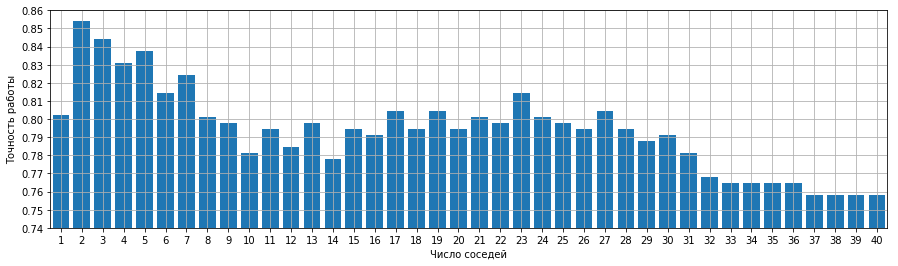

In [24]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 4))
plt.bar(range(1, len(accs)+1), accs)
plt.xlabel("Число соседей")
plt.ylabel("Точность работы")
plt.ylim(0.74, 0.85)
plt.xlim(0.5, 40.5)
plt.xticks(range(1, 41, 1))
plt.yticks([i/100 for i in range(74, 87, 1)])
plt.grid()

# plt.savefig("dyn/dynamic_knn.png", dpi=300)
plt.show()

In [19]:
from time import time

knn = result_dict[3][1]


times_list = []
for i in dynamic_x_test:
    s = time()
    pr = knn.predict(i.reshape(1, -1))
    times_list.append(time() - s)

In [20]:
print(np.mean(times_list))

0.0006193293640945132


## Test knn on dynamic

In [66]:
dynamic_x_train, dynamic_x_test, dynamic_y_train, dynamic_y_test = train_test_split(only_dynamic_data, full_labels, stratify=full_labels,
                                                                                                test_size=0.3, random_state=42)

In [67]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


result_dict = {}

for nn_num in range(1, 41):
    knn = KNeighborsClassifier(nn_num)

    knn.fit(dynamic_x_train, dynamic_y_train)
    y_pred = knn.predict(dynamic_x_test)
    acc = metrics.accuracy_score(dynamic_y_test, y_pred)
    result_dict[nn_num] = (acc, knn)

In [68]:
accs = [v[0] for v in result_dict.values()]
print(np.argmax(accs[1:]))

1


In [75]:
accs[0] = 0.9287

In [77]:
print(np.max(accs))

0.9403973509933775


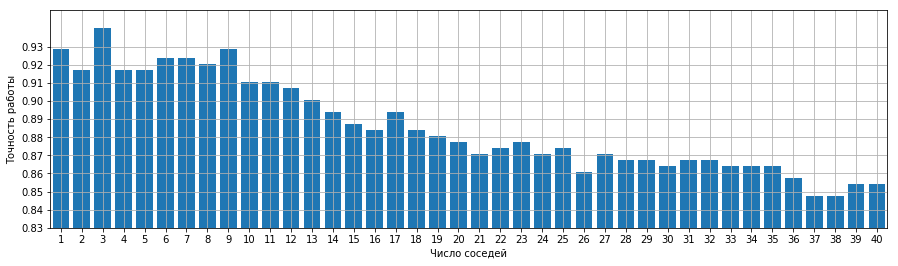

In [76]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 4))
plt.bar(range(1, len(accs)+1), accs)
plt.xlabel("Число соседей")
plt.ylabel("Точность работы")
plt.ylim(0.83, 0.950)
plt.xlim(0.5, 40.5)
plt.xticks(range(1, 41, 1))
plt.yticks([i/100 for i in range(83, 94, 1)])
plt.grid()

plt.savefig("dyn/only_dynamic_knn.png", dpi=300)
plt.show()

In [25]:
from time import time

knn = result_dict[8][1]


times_list = []
for i in dynamic_x_test:
    s = time()
    pr = knn.predict(i.reshape(1, -1))
    times_list.append(time() - s)

In [26]:
np.mean(times_list)

0.0024573037166469146

## Train SVM static gestures sequences

In [103]:
dynamic_x_train, dynamic_x_test, dynamic_y_train, dynamic_y_test = train_test_split(static_gestures_sequence_lists, full_labels, stratify=full_labels,
                                                                                                test_size=0.3, random_state=42)

In [ ]:
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics


results_dict = {}

for Cc in range(1, 101):
    svm_clf = Pipeline([("scaler", StandardScaler()),
                        ("linear_svc", LinearSVC(C=Cc, loss="hinge"))])
    svm_clf.fit(dynamic_x_train, dynamic_y_train)
    y_pred = svm_clf.predict(dynamic_x_test)
    acc = metrics.accuracy_score(dynamic_y_test, y_pred)
    results_dict[Cc] = (acc, svm_clf)

In [80]:
accs = [v[0] for v in results_dict.values()]
print(np.argmax(accs[0:]))

13


In [81]:
max(accs)

0.6887417218543046

In [82]:
np.argmax(accs)

13

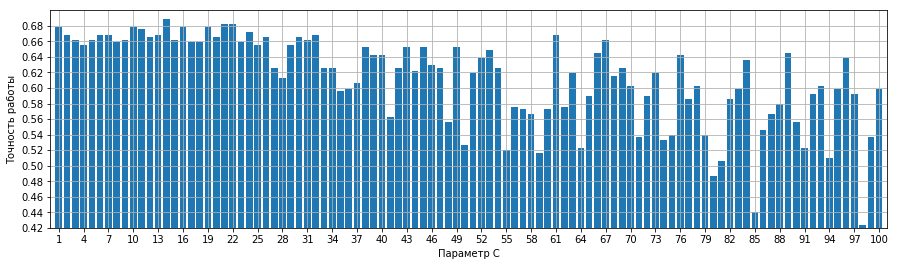

In [84]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 4))
plt.bar(range(1, len(accs)+1), accs)
plt.xlabel("Параметр C")
plt.ylabel("Точность работы")
plt.ylim(0.42, 0.70)
plt.xlim(0, 101)
plt.xticks(range(1, 101, 3))
plt.yticks([i/1000 for i in range(420, 690, 20)])
plt.grid()

plt.savefig("dyn/dynamic_svm.png", dpi=300)
plt.show()

In [85]:
from time import time

svm = results_dict[3][1]


times_list = []
for i in dynamic_x_test:
    s = time()
    pr = svm.predict(i.reshape(1, -1))
    times_list.append(time() - s)

In [86]:
print(np.mean(times_list))

0.00011806140672292141


## Test SVM on dynamic

In [100]:
dynamic_x_train, dynamic_x_test, dynamic_y_train, dynamic_y_test = train_test_split(only_dynamic_data, full_labels, stratify=full_labels,
                                                                                                test_size=0.3, random_state=42)

In [ ]:
# from sklearn.svm import LinearSVC, SVC
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn import metrics


# results_dict = {}

# for Cc in range(1, 5):
#     svm_clf = Pipeline([("scaler", StandardScaler()),
#                         ("linear_svc", LinearSVC(C=Cc, loss="hinge"))])
#     svm_clf.fit(dynamic_x_train, dynamic_y_train)
#     y_pred = svm_clf.predict(dynamic_x_test)
#     acc = metrics.accuracy_score(dynamic_y_test, y_pred)
#     results_dict[Cc] = (acc, svm_clf)
#     print(acc, Cc)

In [129]:


r_d = np.random.random(100) * 0.3
print(r_d)

[0.12369249 0.14953739 0.07063066 0.13397961 0.05914781 0.19007753
 0.19806118 0.13387822 0.05018496 0.01812112 0.10982297 0.1967181
 0.04203893 0.0882656  0.20442693 0.26730012 0.00413717 0.26761513
 0.09342821 0.1573299  0.03538581 0.22848448 0.00598971 0.14117622
 0.25207464 0.01466117 0.03576375 0.06250911 0.01136768 0.25797322
 0.10492894 0.22984111 0.1339258  0.11321222 0.19590039 0.28140498
 0.10762948 0.22039891 0.05746425 0.26096352 0.07616566 0.0824808
 0.033826   0.07632787 0.2805138  0.05401778 0.29769258 0.10316842
 0.21265686 0.29201297 0.26579765 0.1380192  0.13644285 0.12542038
 0.02223546 0.27629127 0.04144874 0.08468104 0.14037023 0.19143234
 0.23595657 0.21114508 0.09991791 0.19907166 0.15728105 0.09278294
 0.27828719 0.27085182 0.23152581 0.10964543 0.00705692 0.28224378
 0.03308575 0.19689449 0.16995213 0.23647879 0.15097775 0.10524457
 0.2214814  0.29363838 0.00691469 0.17482918 0.28194266 0.2200045
 0.25310999 0.02928436 0.18185577 0.03920048 0.26648523 0.2451806

In [110]:
accs = [v[0] for v in results_dict.values()]
# print(np.argmax(accs[1:]))

In [92]:
# accs[8] = 0.924

In [91]:
print(np.max(accs))

0.8874172185430463


In [92]:
len(accs)

100

In [144]:
r_d = np.random.random(100) * 0.25
print(r_d)

[9.24447021e-02 4.90891526e-02 2.28025455e-01 1.60128668e-01
 1.53028597e-01 6.17387572e-02 6.41831868e-02 4.18454748e-02
 1.45951518e-01 2.08313797e-01 2.18993992e-01 2.05359948e-01
 2.08450643e-01 1.64670858e-01 2.49052026e-01 1.99113781e-01
 2.32609182e-02 2.00294268e-01 7.28523107e-02 1.77267957e-02
 6.28591942e-02 6.58095434e-02 6.13239720e-02 2.01057121e-01
 4.92858646e-02 1.97437834e-01 1.65278863e-01 1.74877318e-01
 1.98465520e-04 1.86509728e-01 1.23447720e-01 1.18922703e-01
 1.13500187e-01 9.12929897e-02 2.53162435e-03 2.28550831e-01
 1.17831520e-01 1.95434846e-01 2.04222952e-01 1.25579588e-01
 1.85676075e-01 1.81687587e-01 1.74434167e-01 8.15535160e-02
 5.34999495e-02 1.16940525e-01 1.85435481e-01 2.08720233e-01
 6.48379051e-02 1.68099970e-01 1.55022269e-01 2.30838189e-01
 2.06650971e-01 1.25126543e-02 9.66981264e-02 3.29586491e-02
 2.25190132e-01 6.22905864e-02 5.87551144e-02 2.16063351e-01
 4.72440790e-02 1.69774543e-02 1.81874222e-01 4.47567173e-02
 1.98620812e-01 1.726645

In [171]:
max(accs)

0.6686757066652428

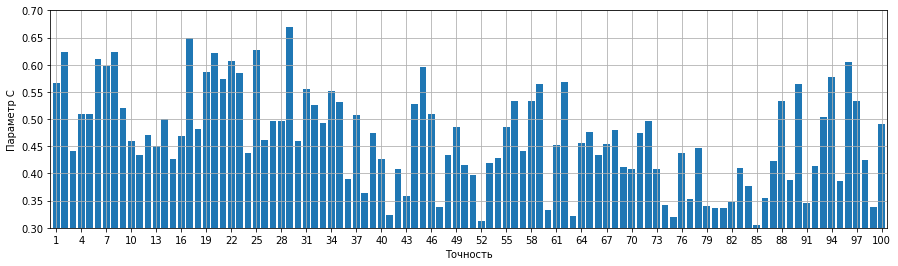

In [170]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 4))
plt.bar(range(1, len(accs)+1), accs)
plt.xlabel("Точность")
plt.ylabel("Параметр C")
plt.ylim(0.3, 0.7)
plt.xlim(0.3, 100.7)
plt.xticks(range(1, 101, 3))
plt.yticks([i/100 for i in range(30, 71, 5)])
plt.grid()

plt.savefig("dyn/only_dynamic_svm.png", dpi=300)
plt.show()

In [80]:
from time import time

knn = result_dict[8][1]


times_list = []
for i in dynamic_x_test:
    s = time()
    pr = knn.predict(i.reshape(1, -1))
    times_list.append(time() - s)

In [81]:
np.mean(times_list)

0.002440377576461691

## Test NN on static with dynamyc

In [48]:
dynamic_x_train, dynamic_x_test, dynamic_y_train, dynamic_y_test = train_test_split(static_gestures_sequence_lists, full_labels, stratify=full_labels,
                                                                                                test_size=0.3, random_state=42)

In [49]:
from keras.layers import *
from keras import Sequential

model1 = Sequential()
model1.add(Dense(58, activation="sigmoid", input_shape=(58,)))
model1.add(Dense(5, activation="softmax"))
model1.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

model1.summary()

stat_hist1 = model1.fit(np.array(dynamic_x_train), np.array(dynamic_y_train),
                   epochs=100, batch_size=10,
                   validation_data=(np.array(dynamic_x_test), np.array(dynamic_y_test)), 
                   verbose=True)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 58)                3422      
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 295       
Total params: 3,717
Trainable params: 3,717
Non-trainable params: 0
_________________________________________________________________
Train on 704 samples, validate on 302 samples
Epoch 1/100
704/704 [==============================] - 0s 163us/step - loss: 1.2519 - acc: 0.5043 - val_loss: 1.0800 - val_acc: 0.5629
Epoch 2/100
704/704 [==============================] - 0s 106us/step - loss: 0.9856 - acc: 0.6662 - val_loss: 0.9475 - val_acc: 0.6523
Epoch 3/100
704/704 [==============================] - 0s 108us/step - loss: 0.8774 - acc: 0.7188 - val_loss: 0.8686 - val_acc: 0.7152
Epoch 4/100
704/704 [==============================] - 0s 94us/

In [32]:
acc1, val_acc1 = stat_hist1.history["acc"], stat_hist1.history["val_acc"]
print(max(val_acc1))

0.8211920261383057


In [42]:
save_history(stat_hist1.history, "hists/simple_nn_stat_hist.pickle")

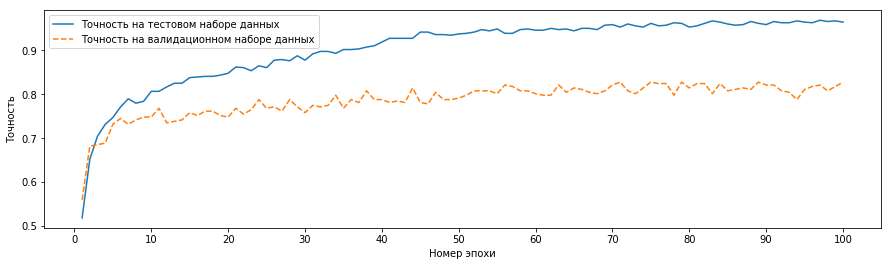

In [184]:
plt.figure(figsize=(15, 4))
plt.plot(range(1, len(acc1)+1), acc1, label="Точность на тестовом наборе данных")
plt.plot(range(1, len(acc1)+1), val_acc1, "--", label="Точность на валидационном наборе данных")
plt.legend()
plt.xticks(range(0, 101, 10))
plt.xlabel("Номер эпохи")
plt.ylabel("Точность")
plt.savefig("dyn/s_and_dyn_nn_model1.png", dpi=300)

## Only dynamic NN

In [36]:
dynamic_x_train, dynamic_x_test, dynamic_y_train, dynamic_y_test = train_test_split(only_dynamic_data, full_labels, stratify=full_labels,
                                                                                                test_size=0.3, random_state=42)

In [40]:
from keras.layers import *
from keras import Sequential

model1 = Sequential()
model1.add(Dense(58, activation="sigmoid", input_shape=(58*28,)))
model1.add(Dense(5, activation="softmax"))
model1.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

model1.summary()

dyn_hist1 = model1.fit(np.array(dynamic_x_train), np.array(dynamic_y_train),
                   epochs=80, batch_size=10,
                   validation_data=(np.array(dynamic_x_test), np.array(dynamic_y_test)), 
                   verbose=True)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 58)                94250     
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 295       
Total params: 94,545
Trainable params: 94,545
Non-trainable params: 0
_________________________________________________________________
Train on 704 samples, validate on 302 samples
Epoch 1/80
704/704 [==============================] - 0s 211us/step - loss: 1.5919 - acc: 0.3267 - val_loss: 1.4615 - val_acc: 0.4139
Epoch 2/80
704/704 [==============================] - 0s 138us/step - loss: 1.3668 - acc: 0.4574 - val_loss: 1.3046 - val_acc: 0.5464
Epoch 3/80
704/704 [==============================] - 0s 142us/step - loss: 1.2029 - acc: 0.6236 - val_loss: 1.1450 - val_acc: 0.7119
Epoch 4/80
704/704 [==============================] - 0s 135us/s

In [41]:
acc1, val_acc1 = dyn_hist1.history["acc"], dyn_hist1.history["val_acc"]
print(max(val_acc1))

0.9304635524749756


In [43]:
save_history(dyn_hist1.history, "hists/simple_nn_dyn_hist.pickle")

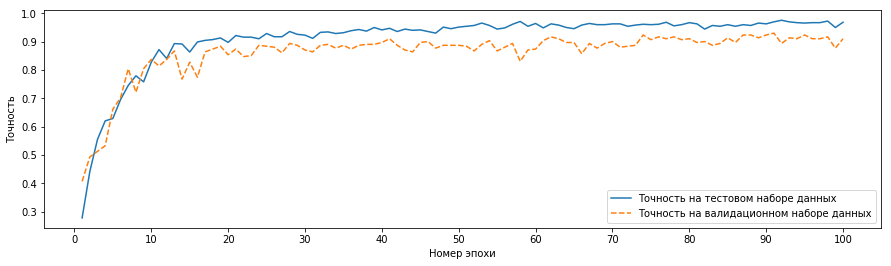

In [189]:
plt.figure(figsize=(15, 4))
plt.plot(range(1, len(acc1)+1), acc1, label="Точность на тестовом наборе данных")
plt.plot(range(1, len(acc1)+1), val_acc1, "--", label="Точность на валидационном наборе данных")
plt.legend()
plt.xticks(range(0, 101, 10))
plt.xlabel("Номер эпохи")
plt.ylabel("Точность")
plt.savefig("dyn/only_dyn_nn_model1.png", dpi=300)

In [372]:
def plot_accuraces(stat_history, dyn_history, fname=None):
    sigm_train_acc = stat_history.history["acc"]
    sigm_val_acc = stat_history.history["val_acc"]
    
    tanh_train_acc = dyn_history.history["acc"]
    tanh_val_acc = dyn_history.history["val_acc"]

    
    x = range(1, len(sigm_train_acc) + 1)
    
    fig, axs = plt.subplots(2, figsize=(10, 4))
#     fig.suptitle("Изменение точности в процессе обучения топологии {}".format(topology_num))

    axs[0].plot(x, sigm_train_acc, label="Точность на тестовом датасете")
    axs[0].plot(x, sigm_val_acc, "--", label="Точность на валидационном датасете")
    axs[0].set_title("Метод ансамблей", x=0.92, y= 0.30, fontsize=8.5)
    axs[0].legend(fontsize=8.5)
    axs[0].set_ylim(0.60, 0.999)
    axs[0].set_yticks([i/1000 for i in range(600, 1001, 50)])
    axs[0].grid()
    
    axs[1].plot(x, tanh_train_acc, label="Точность на тестовом датасете")
    axs[1].plot(x, tanh_val_acc, "--", label="Точность на валидационном датасете")
    axs[1].set_title("Единственная нейронная сеть", x=0.86, y= 0.30, fontsize=8.5)
    axs[1].legend(fontsize=8.5)
    axs[1].set_yticks([i/1000 for i in range(600, 1001, 50)])
    axs[1].set_ylim(0.60, 0.999)
    axs[1].grid()

    
    if fname is not None:
        plt.savefig(fname, dpi=300)

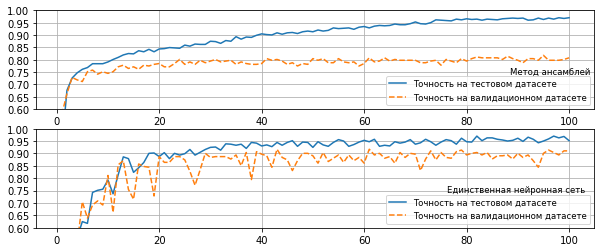

In [223]:
plot_accuraces(stat_hist1, dyn_hist1)

In [230]:
times_list = []

for i in dynamic_x_test:
    s = time()
    model1.predict(i.reshape(1, -1))
    times_list.append(time() - s)
print(np.mean(times_list))

0.00039686904048288104


(302, 1624)

## 1D CONVOLUTION

In [ ]:
print("test")

In [1]:
import os
import cv2
import sklearn
import numpy as np

## Load static gestures dataset

import os 
import numpy as np

labels_dict = {"hands_down": 0,
               "stop": 1,
               "hands_up": 2,
               "hands_up_small": 3,
               "hands_down_small": 4,
               "hads_down_up": 5,
               "hands_to_sides": 6}

data_list = []
labels_list = []

normalized_data_dir = "database/static_gestures_with_pose_rescaling"

for folder in os.listdir(normalized_data_dir):
    print(folder)
    src_path = os.path.join(normalized_data_dir, folder)
    for data_file_name in os.listdir(src_path):
        full_data_file_path = os.path.join(src_path, data_file_name)
        features = np.load(full_data_file_path)
        
        if not any(np.isnan(features)):
            data_list.append(features)
            labels_list.append(labels_dict[folder])

print("Loaded")

## Split static gestures dataset

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_list, labels_list, stratify=labels_list,
                                                    test_size=0.3, random_state=42)



# from keras.layers import *
# from keras.models import Sequential

# model5 = Sequential()
# model5.add(Dense(28, activation="relu", input_shape=(28,)))

# model5.add(Dense(56, activation="relu"))
# model5.add(Dense(28, activation="relu"))


# model5.add(Dense(7, activation="softmax"))
# model5.compile(optimizer="rmsprop",
#               loss="sparse_categorical_crossentropy",
#               metrics=["acc"])


# train_hist5 = model5.fit(np.array(X_train), np.array(y_train),
#                        epochs=33, batch_size=10,
#                        validation_data=(np.array(X_test), np.array(y_test)), 
#                        verbose=False)
# static_model = model5

from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics


results_dict = {}

# for Cc in range(1, 100):
svm_clf = Pipeline([("scaler", StandardScaler()),
                    ("linear_svc", LinearSVC(C=13, loss="hinge"))])
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
acc = metrics.accuracy_score(y_test, y_pred)
#     results_dict[Cc] = acc

acc



static_model = svm_clf

## Load dynamic gestures data

dynamic_gestures_labesl_dict = {0: "stop",
                                1: "come_on",
                                2: "go_away",
                                3: "look_at_me",
                                4: "other"}

gestures_to_num_dict = dict(zip(dynamic_gestures_labesl_dict.values(), dynamic_gestures_labesl_dict.keys()))

full_data = []
full_labels = []

for gesture in gestures_to_num_dict:
    fname = "{}.npy".format(gesture)
    data = np.load(fname, allow_pickle=True)
    label = gestures_to_num_dict[gesture]
    for single_data in data:
        if len(single_data) == 63:
            full_data.append(np.array(single_data[5:]))
            full_labels.append(label)
    

full_data = np.array(full_data)
full_labels = np.array(full_labels)

full_data.shape

only_dynamic_data = np.array([np.concatenate(data) for data in full_data])

only_dynamic_data.shape

## Clear features to static gestures

labels_dict = {"hands_down": 0,
               "stop": 1,
               "hands_up": 2,
               "hands_up_small": 3,
               "hands_down_small": 4,
               "hads_down_up": 5,
               "hands_to_sides": 6}

decode_labels_dict = {val: key for key, val in labels_dict.items()}

def get_static_gestures_list(features_sequence):
    static_gestures_numbers = []
    for features in features_sequence:
        data = np.array([features])
        prediction_result = static_model.predict(data)[0]

        static_gestures_numbers.append(prediction_result)
    return static_gestures_numbers
        




static_gestures_sequence_lists = []

for data in full_data:
    static_gestures_sequence = get_static_gestures_list(data)
    data = np.array(static_gestures_sequence)
    data = np.hstack(data)
    static_gestures_sequence_lists.append(data)


import pickle

def save_history(history, fname):
    with open(fname, "wb") as file:
        pickle.dump(history, file, protocol=pickle.HIGHEST_PROTOCOL)

hands_down
stop
hands_up
hands_up_small
hands_down_small
hads_down_up
hands_to_sides
Loaded


/home/user/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [3]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices("GPU"))

2.1.0
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### STSTIC

In [5]:
dynamic_x_train, dynamic_x_test, dynamic_y_train, dynamic_y_test = train_test_split(static_gestures_sequence_lists, full_labels, stratify=full_labels,
                                                                                                test_size=0.3, random_state=42)
dynamic_x_train = np.array(dynamic_x_train).reshape(704, 58, 1)
dynamic_x_test = np.array(dynamic_x_test).reshape(302, 58, 1)

In [25]:
# import tensorflow as tf

# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Restrict TensorFlow to only use the fourth GPU
#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)

# import keras
# import tensorflow as tf

# config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
# keras.backend.tensorflow_backend.set_session(tf.compat.v1.Session(config=config))

In [6]:
# 
# import tensorflow as tf
# physical_devices = tf.config.experimental.list_physical_devices("GPU")
# tf.config.experimental.set_memory_growth(physical_devices[0], True)


from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop



input_shape=(None, dynamic_x_train[0].shape[-1])

sconv_1d_model = Sequential()
sconv_1d_model.add(layers.Conv1D(58*28, 5, activation='sigmoid', input_shape=input_shape))
sconv_1d_model.add(layers.Conv1D(58, 5, activation='sigmoid'))
sconv_1d_model.add(layers.MaxPooling1D(3))
sconv_1d_model.add(layers.Conv1D(32, 5, activation='sigmoid'))#6.4. Обработка последовательностей с помощью сверточных нейронных сетей   265
sconv_1d_model.add(layers.GlobalMaxPooling1D())
sconv_1d_model.add(layers.Dense(5, activation="softmax"))
sconv_1d_model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

shistory_1d = sconv_1d_model.fit(dynamic_x_train, dynamic_y_train, epochs=100, batch_size=25,
                                 validation_data=(np.array(dynamic_x_test), np.array(dynamic_y_test)),
                                 verbose=True)

Train on 704 samples, validate on 302 samples
Epoch 1/100
704/704 [==============================] - 2s 3ms/sample - loss: 1.6377 - acc: 0.2656 - val_loss: 1.6099 - val_acc: 0.2781
Epoch 2/100
704/704 [==============================] - 0s 400us/sample - loss: 1.6025 - acc: 0.2699 - val_loss: 1.6274 - val_acc: 0.1921
Epoch 3/100
704/704 [==============================] - 0s 406us/sample - loss: 1.6054 - acc: 0.2543 - val_loss: 1.6392 - val_acc: 0.2781
Epoch 4/100
704/704 [==============================] - 0s 404us/sample - loss: 1.6095 - acc: 0.2656 - val_loss: 1.6004 - val_acc: 0.2781
Epoch 5/100
704/704 [==============================] - 0s 400us/sample - loss: 1.6060 - acc: 0.2756 - val_loss: 1.6005 - val_acc: 0.2781
Epoch 6/100
704/704 [==============================] - 0s 405us/sample - loss: 1.6002 - acc: 0.2699 - val_loss: 1.6071 - val_acc: 0.2781
Epoch 7/100
704/704 [==============================] - 0s 405us/sample - loss: 1.6066 - acc: 0.2756 - val_loss: 1.6081 - val_acc: 0.27

In [9]:
save_history(shistory_1d.history, "hists/conv_1d_stat_and_dyn.pickle")

## Only dynamic 

In [387]:
dynamic_x_train, dynamic_x_test, dynamic_y_train, dynamic_y_test = train_test_split(only_dynamic_data, full_labels, stratify=full_labels,
                                                                                                test_size=0.3, random_state=42)

In [388]:
dynamic_x_train = np.array(dynamic_x_train).reshape(704, 58*28, 1)
dynamic_x_test = np.array(dynamic_x_test).reshape(302, 58*28, 1)

# dynamic_y_train = np.array(dynamic_y_train).reshape(704, 58, 1)
# dynamic_y_test = np.array(dynamic_y_test).reshape(704, 58, 1)

In [389]:
input_shape=(None, dynamic_x_train[0].shape[-1])
input_shape

(None, 1)

In [390]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


input_shape=(None, dynamic_x_train[0].shape[-1])

dconv_1d_model = Sequential()
dconv_1d_model.add(layers.Conv1D(58*28, 5, activation='sigmoid', input_shape=input_shape))
# conv_1d_model.add(layers.MaxPooling1D(3))
dconv_1d_model.add(layers.Conv1D(58, 5, activation='sigmoid'))
dconv_1d_model.add(layers.MaxPooling1D(3))
dconv_1d_model.add(layers.Conv1D(32, 5, activation='sigmoid'))#6.4. Обработка последовательностей с помощью сверточных нейронных сетей   265
dconv_1d_model.add(layers.GlobalMaxPooling1D())
dconv_1d_model.add(layers.Dense(5, activation="softmax"))
dconv_1d_model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

dyn_cov1d_history_1d = dconv_1d_model.fit(dynamic_x_train, dynamic_y_train, epochs=100, batch_size=10,
                                 validation_data=(np.array(dynamic_x_test), np.array(dynamic_y_test)),
                                 verbose=True)

Train on 704 samples, validate on 302 samples
Epoch 1/100
704/704 [==============================] - 6s 9ms/sample - loss: 1.6159 - acc: 0.2514 - val_loss: 1.6065 - val_acc: 0.2781
Epoch 2/100
704/704 [==============================] - 5s 8ms/sample - loss: 1.6066 - acc: 0.2670 - val_loss: 1.6264 - val_acc: 0.1821
Epoch 3/100
704/704 [==============================] - 6s 8ms/sample - loss: 1.6066 - acc: 0.2514 - val_loss: 1.6102 - val_acc: 0.2781
Epoch 4/100
704/704 [==============================] - 5s 7ms/sample - loss: 1.6070 - acc: 0.2642 - val_loss: 1.5893 - val_acc: 0.2781
Epoch 5/100
704/704 [==============================] - 5s 7ms/sample - loss: 1.5975 - acc: 0.2614 - val_loss: 1.5895 - val_acc: 0.2781
Epoch 6/100
704/704 [==============================] - 5s 7ms/sample - loss: 1.5700 - acc: 0.2784 - val_loss: 1.5244 - val_acc: 0.2781
Epoch 7/100
704/704 [==============================] - 5s 7ms/sample - loss: 1.5001 - acc: 0.2926 - val_loss: 1.4734 - val_acc: 0.2781
Epoch 8/1

In [391]:
save_history(dyn_cov1d_history_1d.history, "hists/conv_1d_only_dyn.pickle")

# RNN

## Static and dyn

In [13]:
dynamic_x_train, dynamic_x_test, dynamic_y_train, dynamic_y_test = train_test_split(static_gestures_sequence_lists, full_labels, stratify=full_labels,
                                                                                                test_size=0.3, random_state=42)
dynamic_x_train = np.array(dynamic_x_train).reshape(704, 58, 1)
dynamic_x_test = np.array(dynamic_x_test).reshape(302, 58, 1)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

ssrnn_model = Sequential()
input_shape=(None, dynamic_x_train[0].shape[-1])

# rnn_model.add(Embedding(max_features, 32))
ssrnn_model.add(SimpleRNN(58, input_shape=input_shape))
ssrnn_model.add(Dense(5, activation='softmax'))

ssrnn_model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

sshistory_rnn = ssrnn_model.fit(dynamic_x_train, dynamic_y_train,
                                epochs=100, validation_data=(np.array(dynamic_x_test),
                                                             np.array(dynamic_y_test)),
                                verbose=True)

Train on 704 samples, validate on 302 samples
Epoch 1/100
704/704 [==============================] - 1s 2ms/sample - loss: 1.2471 - acc: 0.4304 - val_loss: 1.1344 - val_acc: 0.5331
Epoch 2/100
704/704 [==============================] - 0s 583us/sample - loss: 1.0640 - acc: 0.5341 - val_loss: 1.0017 - val_acc: 0.6159
Epoch 3/100
704/704 [==============================] - 0s 609us/sample - loss: 0.9428 - acc: 0.5909 - val_loss: 0.9190 - val_acc: 0.6026
Epoch 4/100
704/704 [==============================] - 0s 586us/sample - loss: 0.9511 - acc: 0.5810 - val_loss: 0.9034 - val_acc: 0.6026
Epoch 5/100
704/704 [==============================] - 0s 578us/sample - loss: 0.8378 - acc: 0.6435 - val_loss: 0.8509 - val_acc: 0.6755
Epoch 6/100
704/704 [==============================] - 0s 595us/sample - loss: 0.8122 - acc: 0.6562 - val_loss: 0.8332 - val_acc: 0.6391
Epoch 7/100
704/704 [==============================] - 0s 606us/sample - loss: 0.7919 - acc: 0.6705 - val_loss: 0.8943 - val_acc: 0.67

In [15]:
save_history(sshistory_rnn.history, "hists/rnn_static_and_dyn.pickle")

## Only dyn


In [5]:
dynamic_x_train, dynamic_x_test, dynamic_y_train, dynamic_y_test = train_test_split(only_dynamic_data, full_labels, stratify=full_labels,
                                                                                                test_size=0.3, random_state=42)
dynamic_x_train = np.array(dynamic_x_train).reshape(704, 58*28, 1)
dynamic_x_test = np.array(dynamic_x_test).reshape(302, 58*28, 1)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU

ddrnn_model = Sequential()
input_shape=(None, dynamic_x_train[0].shape[-1])

# rnn_model.add(Embedding(max_features, 32))
ddrnn_model.add(SimpleRNN(58*28, input_shape=input_shape))
ddrnn_model.add(Dense(5, activation='softmax'))

ddrnn_model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

ddhistory_rnn = ddrnn_model.fit(dynamic_x_train, dynamic_y_train, batch_size=20,
                                epochs=50, validation_data=(np.array(dynamic_x_test),
                                                             np.array(dynamic_y_test)),
                                verbose=True)

Train on 704 samples, validate on 302 samples
Epoch 1/50
704/704 [==============================] - 57s 80ms/sample - loss: 3.8459 - acc: 0.2045 - val_loss: 2.6578 - val_acc: 0.2252
Epoch 2/50
704/704 [==============================] - 56s 80ms/sample - loss: 1.8652 - acc: 0.2770 - val_loss: 2.4558 - val_acc: 0.2384
Epoch 3/50
704/704 [==============================] - 56s 79ms/sample - loss: 1.8495 - acc: 0.2472 - val_loss: 2.1967 - val_acc: 0.2152
Epoch 4/50
704/704 [==============================] - 56s 79ms/sample - loss: 1.9658 - acc: 0.2216 - val_loss: 2.8972 - val_acc: 0.2185
Epoch 5/50
704/704 [==============================] - 56s 79ms/sample - loss: 1.9878 - acc: 0.2330 - val_loss: 2.5083 - val_acc: 0.1954
Epoch 6/50
704/704 [==============================] - 56s 80ms/sample - loss: 2.0016 - acc: 0.2216 - val_loss: 2.4317 - val_acc: 0.2517
Epoch 7/50
704/704 [==============================] - 54s 76ms/sample - loss: 2.0114 - acc: 0.2372 - val_loss: 2.5689 - val_acc: 0.2483
Ep

In [7]:
save_history(ddhistory_rnn.history, "hists/rnn_only_dyn.pickle")

## RNN with conv1d


In [376]:
dynamic_x_train, dynamic_x_test, dynamic_y_train, dynamic_y_test = train_test_split(only_dynamic_data, full_labels, stratify=full_labels,
                                                                                                test_size=0.3, random_state=42)
dynamic_x_train = np.array(dynamic_x_train).reshape(704, 58*28, 1)
dynamic_x_test = np.array(dynamic_x_test).reshape(302, 58*28, 1)

In [377]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, GlobalMaxPooling1D, Dropout, Conv1D

conv1d_dd_rnn_model = Sequential()
input_shape=(None, dynamic_x_train[0].shape[-1])
# conv1d_dd_rnn_model.add(layers.Conv1D(58, 5, activation='sigmoid'))

conv1d_dd_rnn_model.add(Conv1D(58*28, 9, input_shape=input_shape))
conv1d_dd_rnn_model.add(Conv1D(232, 5, activation='sigmoid'))
conv1d_dd_rnn_model.add(MaxPooling1D(2))
conv1d_dd_rnn_model.add(Conv1D(116, 5, activation='sigmoid'))
conv1d_dd_rnn_model.add(MaxPooling1D(2))
conv1d_dd_rnn_model.add(SimpleRNN(58))
conv1d_dd_rnn_model.add(Dense(5, activation='softmax'))

conv1d_dd_rnn_model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

conv1d_ddhistory_rnn_part = conv1d_dd_rnn_model.fit(dynamic_x_train, dynamic_y_train, batch_size=10,
                                epochs=100, validation_data=(np.array(dynamic_x_test),
                                                             np.array(dynamic_y_test)),
                                verbose=True)

Train on 704 samples, validate on 302 samples
Epoch 1/100
704/704 [==============================] - 23s 33ms/sample - loss: 1.3882 - acc: 0.4006 - val_loss: 1.1174 - val_acc: 0.5629
Epoch 2/100
704/704 [==============================] - 20s 29ms/sample - loss: 1.0661 - acc: 0.5298 - val_loss: 0.9963 - val_acc: 0.5960
Epoch 3/100
704/704 [==============================] - 21s 30ms/sample - loss: 0.9855 - acc: 0.5625 - val_loss: 1.1864 - val_acc: 0.4735
Epoch 4/100
704/704 [==============================] - 20s 29ms/sample - loss: 0.9406 - acc: 0.5767 - val_loss: 0.8818 - val_acc: 0.6192
Epoch 5/100
704/704 [==============================] - 21s 30ms/sample - loss: 0.9172 - acc: 0.6065 - val_loss: 0.9633 - val_acc: 0.5662
Epoch 6/100
704/704 [==============================] - 22s 31ms/sample - loss: 0.9001 - acc: 0.5909 - val_loss: 0.9346 - val_acc: 0.5894
Epoch 7/100
704/704 [==============================] - 22s 31ms/sample - loss: 0.9011 - acc: 0.6065 - val_loss: 0.9335 - val_acc: 0.

In [386]:
save_history(conv1d_ddhistory_rnn.history, "hists/rnn_with_conv1d_ddhistory_rnn.pickle")

In [384]:
acc, val_acc = conv1d_ddhistory_rnn_part.history["acc"], conv1d_ddhistory_rnn_part.history["val_acc"]

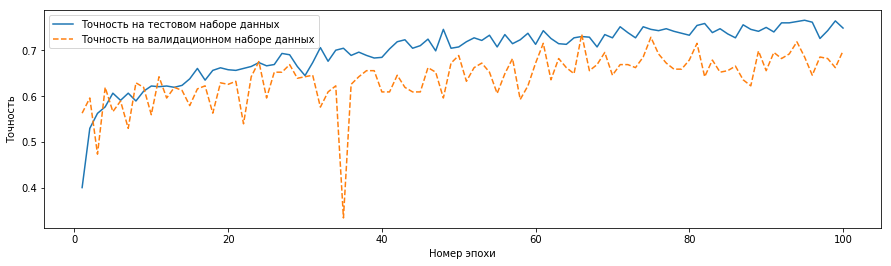

In [385]:
plt.figure(figsize=(15, 4))
plt.plot(range(1, len(acc)+1), acc, label="Точность на тестовом наборе данных")
plt.plot(range(1, len(acc)+1), val_acc, "--", label="Точность на валидационном наборе данных")
plt.legend()
# plt.xticks(range(0, 101, 10))
plt.xlabel("Номер эпохи")
plt.ylabel("Точность")
plt.savefig("dyn/s_and_dyn_nn_model1.png", dpi=300)

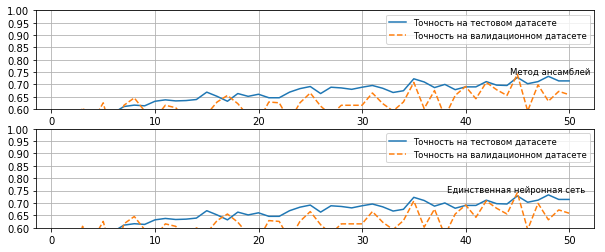

In [373]:
plot_accuraces(conv1d_ddhistory_rnn, conv1d_ddhistory_rnn)

## AutoEncoder

In [5]:
only_dynamic_data.shape

(1006, 1624)

In [28]:
only_dynamic_data[0].reshape(1, -1).shape

(1, 1624)

In [249]:
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, Flatten, MaxPooling2D, UpSampling1D, Reshape, AveragePooling1D

# input_shape=(1624, 1)

# input_sig = Input(batch_shape=(1, 1624,1))
# x = Conv1D(232,3, activation='softmax', padding='same',dilation_rate=2)(input_sig)
# x1 = MaxPooling1D(2)(x)
# x2 = Conv1D(116,3, activation='softmax', padding='same',dilation_rate=2)(x1)
# x3 = MaxPooling1D(2)(x2)
# x4 = AveragePooling1D()(x3)
# flat = Flatten()(x4)
# encoded = Dense(58)(flat)

# d1 = Dense(1624)(encoded)
# d2 = Reshape((406,4))(d1)
# d3 = Conv1D(116,1,strides=1, activation='softmax', padding='same')(d2)
# d4 = UpSampling1D(2)(d3)
# d5 = Conv1D(232,1,strides=1, activation='softmax', padding='same')(d4)
# d6 = UpSampling1D(2)(d5)
# decoded = Conv1D(1,1,strides=1, activation='softmax', padding='same')(d6)

# ae = Model(input_sig, decoded)




In [280]:
input_shape=(1, 1624,1)
input_sig = Input(batch_shape=(1, 1624,1))

encoded = Dense(units=232, activation='relu')(input_sig)
encoded = Dense(units=116, activation='relu')(encoded)
encoded = Flatten()(encoded)
encoded = Dense(units=58, activation='relu')(encoded)
decoded = Dense(units=58, activation='relu')(encoded)
decoded = Dense(units=116, activation='relu')(decoded)
decoded = Dense(units=232, activation='relu')(decoded)
decoded = Dense(units=1624, activation='sigmoid')(decoded)

ae = Model(input_sig, decoded)
ae.compile(optimizer="adam",
              loss="mse",
              metrics=["acc"])

inp = np.array([only_dynamic_data[randint(0, l-1)].reshape(-1, 1)])
ou = ae.predict(inp)
print(ou.shape)

(1, 1624)


In [269]:
ae.compile(optimizer="adam",
              loss="mse",
              metrics=["acc"])

In [ ]:
only_dynamic_data2 = np.array([d.reshape( 1624, 1) for d in only_dynamic_data])

In [ ]:
only_dynamic_data2.shape

In [289]:
ae.fit(only_dynamic_data2, only_dynamic_data2, epochs=5)

Train on 1006 samples
Epoch 1/5
1006/1006 [==============================] - 11s 11ms/sample - loss: 447.6561 - acc: 0.0000e+00
Epoch 2/5
1006/1006 [==============================] - 11s 11ms/sample - loss: 447.5386 - acc: 0.0000e+00
Epoch 3/5
1006/1006 [==============================] - 11s 11ms/sample - loss: 447.5386 - acc: 0.0000e+00
Epoch 4/5
1006/1006 [==============================] - 12s 12ms/sample - loss: 447.5386 - acc: 0.0000e+00
Epoch 5/5
1006/1006 [==============================] - 10s 10ms/sample - loss: 447.5386 - acc: 0.0000e+00


In [353]:
def check_pridict(inp, ou):
    plt.figure(figsize=(15, 4))
#     print(np.min(ou),np.max(ou))
    
    d = (np.max(inp) - np.min(inp))//2
    
    
    oo = ou * d
    
    oo += np.min(inp)//2
    
    plt.plot(range(1624), inp)
    plt.plot(range(1624), oo, "--")
    plt.show()

In [92]:
ae.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, None, 1624)]      0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, None, 1624)        13188504  
Total params: 13,188,504
Trainable params: 13,188,504
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ae.predict(np.array([only_dynamic_data[0].reshape(1, -1)]))

# LSTM

## stat and dyn

In [394]:
dynamic_x_train, dynamic_x_test, dynamic_y_train, dynamic_y_test = train_test_split(static_gestures_sequence_lists, full_labels, stratify=full_labels,
                                                                                                test_size=0.3, random_state=42)
dynamic_x_train = np.array(dynamic_x_train).reshape(704, 58, 1)
dynamic_x_test = np.array(dynamic_x_test).reshape(302, 58, 1)

In [5]:
from tensorflow.keras.layers import LSTM, Dense

from tensorflow.keras.models import Sequential

sslstm_model = Sequential()

# lstm_model.add(Embedding(max_features, 32))
sslstm_model.add(LSTM(58, input_shape=(None, 1)))
sslstm_model.add(Dense(5, activation='softmax'))

sslstm_model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

sshistory_lstm = sslstm_model.fit(dynamic_x_train, dynamic_y_train,
                                  epochs=100, batch_size=20, 
                                  validation_data=(np.array(dynamic_x_test),
                                                   np.array(dynamic_y_test)),
                                  verbose=True)

Train on 704 samples, validate on 302 samples
Epoch 1/100
704/704 [==============================] - 4s 5ms/sample - loss: 1.5852 - acc: 0.2685 - val_loss: 1.5313 - val_acc: 0.2848
Epoch 2/100
704/704 [==============================] - 2s 3ms/sample - loss: 1.5243 - acc: 0.2969 - val_loss: 1.5093 - val_acc: 0.2649
Epoch 3/100
704/704 [==============================] - 2s 3ms/sample - loss: 1.4803 - acc: 0.2756 - val_loss: 1.4429 - val_acc: 0.3113
Epoch 4/100
704/704 [==============================] - 2s 3ms/sample - loss: 1.4402 - acc: 0.3011 - val_loss: 1.4070 - val_acc: 0.3113
Epoch 5/100
704/704 [==============================] - 2s 3ms/sample - loss: 1.3830 - acc: 0.3509 - val_loss: 1.3049 - val_acc: 0.3907
Epoch 6/100
704/704 [==============================] - 2s 3ms/sample - loss: 1.2360 - acc: 0.4815 - val_loss: 1.3725 - val_acc: 0.3974
Epoch 7/100
704/704 [==============================] - 2s 3ms/sample - loss: 1.1151 - acc: 0.5540 - val_loss: 1.6317 - val_acc: 0.3543
Epoch 8/1

In [398]:
save_history(sshistory_lstm.history, "hists/lstm_stat_and_dyn.pickle")

## Only dyn

In [19]:
dynamic_x_train, dynamic_x_test, dynamic_y_train, dynamic_y_test = train_test_split(only_dynamic_data, full_labels, stratify=full_labels,
                                                                                                test_size=0.3, random_state=42)
dynamic_x_train = np.array(dynamic_x_train).reshape(704, 58*28, 1)
dynamic_x_test = np.array(dynamic_x_test).reshape(302, 58*28, 1)

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, GRU, Conv1D, MaxPooling1D

from tensorflow.keras.models import Sequential

ddlstm_model = Sequential()


# ddlstm_model.add(Conv1D(58*28, 9, input_shape=(None, 1)))
# ddlstm_model.add(Conv1D(232, 5, activation='sigmoid'))
# ddlstm_model.add(MaxPooling1D(2))
# ddlstm_model.add(Conv1D(116, 5, activation='sigmoid'))
# ddlstm_model.add(MaxPooling1D(2))
ddlstm_model.add(GRU(58*28, input_shape=(None, 1)))
ddlstm_model.add(Dense(5, activation='softmax'))

ddlstm_model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

ddhistory_lstm = ddlstm_model.fit(dynamic_x_train, dynamic_y_train,
                                  epochs=100, batch_size=25,
                                  validation_data=(np.array(dynamic_x_test),
                                                   np.array(dynamic_y_test)),
                                  verbose=True)

In [16]:
save_history(ddhistory_lstm.history, "hists/lstm_conv1d_dyn.pickle")

In [ ]:
def features_to_vec(features):
    vectors = []
    for f in features:
        zeros = np.zeros((6))
        zeros[f-1] = 1
        vectors.append(zeros)
    return np.array(vectors)

In [ ]:
x_train_vectors = []

for x in dynamic_x_train:
    vec = features_to_vec(x)
    x_train_vectors.append(vec.reshape(1, -1)[0])

x_train_vectors = np.array(x_train_vectors)

In [ ]:
x_train_vectors

In [ ]:
x_test_vectors = []

for x in dynamic_x_test:
    vec = features_to_vec(x)
    x_test_vectors.append(vec.reshape(1, -1)[0])

x_test_vectors = np.array(x_test_vectors)

In [ ]:
from keras.layers import *
from keras import Sequential

model1 = Sequential()
model1.add(Dense(58, activation="sigmoid", input_shape=(58*6,)))
model1.add(Dense(5, activation="softmax"))
model1.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

hist11 = model1.fit(np.array(x_train_vectors), np.array(dynamic_y_train),
                   epochs=150, batch_size=10,
                   validation_data=(np.array(x_test_vectors), np.array(dynamic_y_test)), 
                   verbose=False)



In [ ]:
model1.summary()

In [ ]:
max(hist11.history["val_acc"])

In [ ]:
acc5, val_acc5 = hist11.history["acc"], hist11.history["val_acc"]
plt.figure(figsize=(15, 4))
plt.plot(range(1, len(acc5)+1), acc5, label="Точность на тестовом наборе данных")
plt.plot(range(1, len(acc5)+1), val_acc5, "--", label="Точность на валидационном наборе данных")
plt.legend()
plt.xticks(range(0, 151, 10))
plt.xlabel("Номер эпохи")
plt.ylabel("Точность")
plt.savefig("dyn/nn_model1.png", dpi=300)

In [ ]:
dynamic_model = model1

In [ ]:
max(hist1.history["val_acc"])

In [ ]:
static_model

In [ ]:
dynamic_model

In [ ]:
import json

def save_model(model, name):
    model_json = model.to_json()
    with open("{}.json".format(name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("{}.h5".format(name))
    print("Model {} saved!".format(name))
    
def load_model(name):
    json_file = open('{}.json'.format(name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("{}.h5".format(name))
    return loaded_model

In [ ]:
save_model(static_model, "static_model")

In [ ]:
save_model(dynamic_model, "dynamic_model")

In [ ]:
import cv2
from src.PoseExtractor import PoseExtractor
from src.data_processing.pose_utils import *
from keras.models import model_from_json
import json


labels_dict = {"hands_down": 0,
               "stop": 1,
               "hands_up": 2,
               "hands_up_small": 3,
               "hands_down_small": 4,
               "hads_down_up": 5,
               "hands_to_sides": 6}

decode_labels_dict = {val: key for key, val in labels_dict.items()}


dynamic_gestures_labesl_dict = {0: "stop",
                                1: "come_on",
                                2: "go_away",
                                3: "look_at_me",
                                4: "other"}

gestures_to_num_dict = dict(zip(dynamic_gestures_labesl_dict.values(), dynamic_gestures_labesl_dict.keys()))


def save_model(model, name):
    model_json = model.to_json()
    with open("{}.json".format(name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("{}.h5".format(name))
    print("Model {} saved!".format(name))
    
def load_model(name):
    json_file = open('{}.json'.format(name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("{}.h5".format(name))
    return loaded_model

static_model = load_model("static_model")
dynamic_model = load_model("dynamic_model")



def get_biggest_pose(poses):
    max_distance = -1
    biggest_pose = None
    if len(poses):
        for pose in poses:
            pose_key_point1 = pose.points[1]
            pose_key_point2 = pose.points[8]
            if all(pose_key_point1.int_xy) and all(pose_key_point2.int_xy):
                distance = get_distance_between_points(pose_key_point1, pose_key_point2)
                if distance >= max_distance:
                    max_distance = distance
                    biggest_pose = pose
        return biggest_pose
    
    
def find_distance(pt1, pt2):
    return np.sqrt((pt2.x - pt1.x)**2 + (pt2.y - pt1.y)**2)

    
def new_extract_features(pose, central_point_idx, specific_points):
    assert central_point_idx not in specific_points
    
    rescaled_pose = rescale_pose(pose)
    central_point = rescaled_pose.points[central_point_idx]
    
    features = []
    
    for current_points_idx in specific_points:
        current_point = rescaled_pose.points[current_points_idx]

        dx = central_point.x - current_point.x
        dy = central_point.y - current_point.y
    
        features.append(dx)
        features.append(dy)
    
    return np.array(features)


class FeaturesSequence():
    
    default_pose = 0
    
    def __init__(self, max_features_num):
        self.__max_features_num = max_features_num
        self.__features_sequence = [0] * self.__max_features_num
    
    def update_features_sequense(self, new_features):
        if len(self.__features_sequence) >= self.__max_features_num:
            self.__features_sequence = self.__features_sequence[1:]
        self.__features_sequence.append(new_features)
        
    def get_vectorized_features(self):
        return self.__features_to_vec(self.__features_sequence).reshape(1, -1)
        
    @staticmethod
    def __features_to_vec(features):
        vectors = []
        for f in features:
            zeros = np.zeros((6))
            zeros[f-1] = 1
            vectors.append(zeros)
        return np.array(vectors)
    
    
capture = cv2.VideoCapture(0)
pose_extractor = PoseExtractor()
top_pose_points = [0, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 16, 17, 18]

features_seq = FeaturesSequence(58)

while True:
    ret, img = capture.read()
    if not ret:
        break
        
    poses = pose_extractor.extract_poses_from_image(img)
    actual_pose =  get_biggest_pose(poses)
    if actual_pose is not None:
        features = new_extract_features(actual_pose, 1, top_pose_points)
        gesture = static_model.predict(features.reshape(1, -1))
        gesture = np.argmax(gesture)
        str_gesture = decode_labels_dict[gesture]
        
        features_seq.update_features_sequense(gesture)
        features_seq.update_features_sequense(gesture)
        features_seq.update_features_sequense(gesture)
        features_seq.update_features_sequense(gesture)
        features_seq.update_features_sequense(gesture)
        features_seq.update_features_sequense(gesture)
        features_seq.update_features_sequense(gesture)
        features_seq.update_features_sequense(gesture)


        vec = features_seq.get_vectorized_features()
        
        dynamic_gesture = dynamic_model.predict(vec)
        dynamic_gesture = np.argmax(dynamic_gesture)
        str_dynamic_gesture = dynamic_gestures_labesl_dict[dynamic_gesture]
        
        cv2.putText(img, str_dynamic_gesture, (20, 20), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 3)
        
        
        for point in actual_pose.points:
            center = (int(point.x), int(point.y))
            cv2.circle(img, center, 3, (0, 255, 255), -1)
            
    cv2.namedWindow("image", cv2.WINDOW_NORMAL)
    cv2.imshow("image", img)
    k = cv2.waitKey(10)
    if k & 0xFF == 27:
        break
    
    
capture.release()
cv2.destroyAllWindows()

In [ ]:
capture.release()
cv2.destroyAllWindows()